# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [2]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from itertools import product as it_product

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

[example notebook: link](https://github.com/gakhov/pycon-ua-2018/blob/master/stochastic-models.ipynb)

# Parameters

In [6]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [7]:
all_data_path = r'../../data/snow_data_clean.pkl'

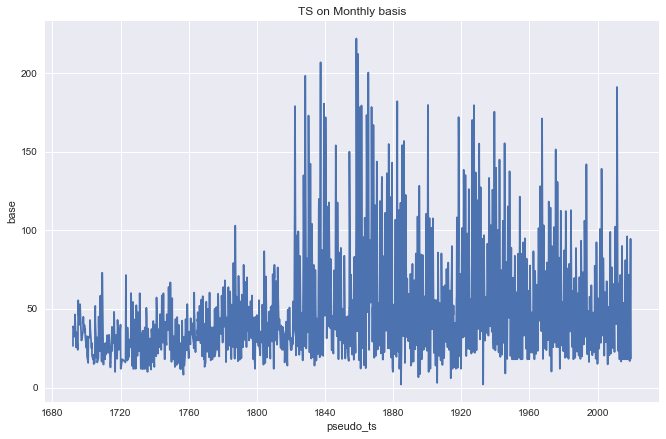

In [8]:
long_series_df = pd.read_pickle(all_data_path)
month_ts_df = pd.DataFrame()
month_ts_df['base'] = long_series_df.set_index('pseudo_ts').base.resample('M').mean()
month_ts_df['snowfall'] = long_series_df.set_index('pseudo_ts').snowfall.resample('M').sum()
g = sns.lineplot(data=month_ts_df.reset_index(), x='pseudo_ts', y='base')
g.set_title("TS on Monthly basis");

In [9]:
co_base_ts = (long_series_df
              .query('region=="Colorado"')
              [['base', 'pseudo_ts']]
              .sort_values(by='pseudo_ts')
             )
co_base_ts_valuearr = co_base_ts.values[:,0].astype(np.single)

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [18]:
def AC_PAC_plotter(df=None, lags=None, differences=None):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    smg.tsaplots.plot_acf(x=df.base,
                                    lags=lags, alpha=0.05, 
                                    use_vlines=True, unbiased=False,
                                    missing='conservative',
                                    title=f'Autocorrelation: Differencing: {differences}', 
                                    zero=True, ax=ax1
                                   )
    smg.tsaplots.plot_pacf(x=df.base, lags=lags,
                       alpha=0.05, method='ywunbiased', use_vlines=True, 
                       title='Partial Autocorrelation', zero=True, 
                       vlines_kwargs=None, ax=ax2)
    fig;

In [19]:
def resid_plotter(residuals=None, y=None):
    """plot residual errors"""
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    residuals.plot(title="Residuals over Time", ax=ax1)
    residuals.plot(kind='kde', title="Residuals Distribution", ax=ax2)
    plt.show()
    print(residuals.describe())


In [20]:
def y_and_yhat_plotter(model=None, endog=None, query_filter=None, date_between=None):
    """endog should be df with time series data and pseudo_ts"""
    df = endog.copy()
    df.columns = ['y', 'pseudo_ts']
    yhat = model.fit().predict()
    df['yhat'] = yhat
    if query_filter:
        df = df.query(query_filter)
    if date_between:
        df = df.loc[df.pseudo_ts.between(*date_between)]
    df = df.melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(data=df, x='pseudo_ts', y='value', hue='variable')
    plt.show();

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation since this is a time series problem.

In [30]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for statsmodels ARIMA models """
    def __init__(self, model_class, order, seasonal_order=None):
        self.model_class = model_class
        self.order=order
        self.seasonal_order=seasonal_order
    def fit(self, endog=None, exog=None):
        self.endog = endog
        self.exog=exog
        self.sm_model_ = self.model_class(endog=self.endog, exog=self.exog, 
                                       order=self.order, 
                                       seasonal_order=self.seasonal_order)
        self.results_ = self.sm_model_.fit()
        self.mse, self.mae = self.results_.mse, self.results_.mae
        self.bic, self.aic = self.results_.bic, self.results_.aic
        return self.results_
    def predict(self, X):
        return self.results_.predict(X)
    def summary(self):
        return self.results_.summary()

In [31]:
def time_crossval(model, X, y):
    """takes sklearn-API model and returns CV results"""
    time_split = TimeSeriesSplit(8)
    cv_results = cross_validate(model, X, y, cv=time_split, 
                            scoring=['neg_root_mean_squared_error', 'r2',
                                     'neg_mean_absolute_error'], n_jobs=-1) 
    return cv_results

In [69]:
def IC_chooser(unwrapped_mod, X, y, order_limit):
    """Use AIC/BIC to choose best model from grid of (pdq)(PDQ)S models
    Params:
        model:  sklearn model
        X:  
        y:
        order_limit:  highest order to use for pdq/PDQ
    Returns:
        df of AIC/BIC statistics
    """
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, order_limit)
    # Generate all different combinations of p, q and q triplets
    pdq = list(it_product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(it_product(p, d, q))]
    AIC, BIC = {}, {}
    for order in pdq:
        for season_order in seasonal_pdq:
            model = SMWrapper(unwrapped_mod, order=order, seasonal_order=season_order)
            model.fit(endog=X)
            AIC[f"({order}),({season_order})12"] = model.aic
            BIC[f"({order}),({season_order})12"] = model.bic
    ic_df = (pd.DataFrame.from_dict(AIC, orient='index').rename(columns={0:"AIC"})
             .merge(right=
                   pd.DataFrame.from_dict(BIC, orient='index').rename(columns={0:"BIC"}),
                   left_index=True, right_index=True)
             .sort_values(by='BIC', ascending=True)
             )
    return ic_df

## ARIMA and extensions

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

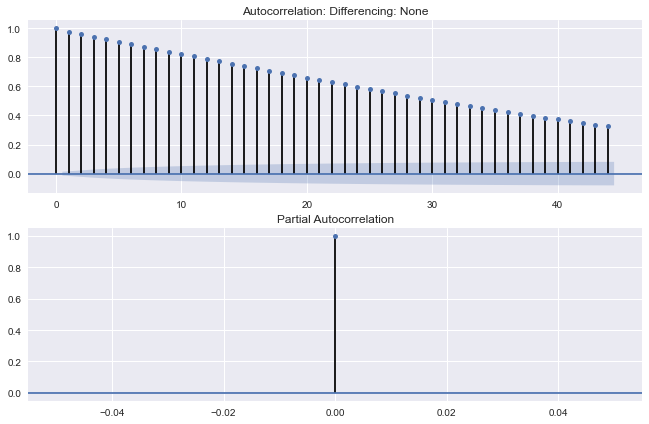

In [25]:
AC_PAC_plotter(co_base_ts)

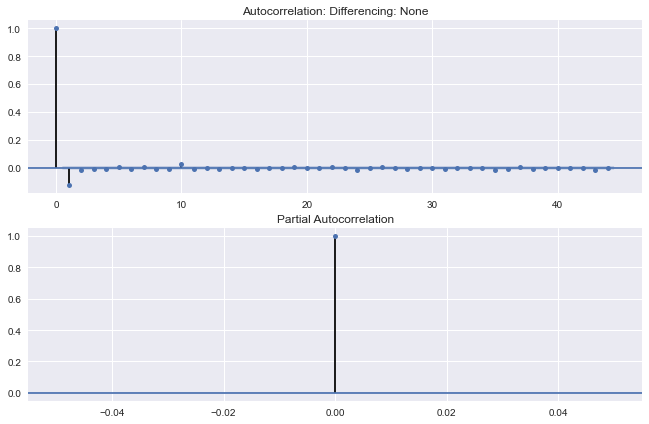

In [26]:
AC_PAC_plotter(co_base_ts.diff(periods=1))

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.
I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [27]:
 # (p, d, q) | (AR, diff, MA) ; need to slice values to get rid of ts data
arima_model = SMWrapper(model_class=smt.arima.model.ARIMA, 
                        order=(0, 1, 1))


arima_model_fit = arima_model.fit(endog=co_base_ts_valuearr)

In [ ]:
time_crossval(arima_model, month_ts_df.base, month_ts_df.base.shift(1).fillna(0))

In [70]:
IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=month_ts_df.base.iloc[0:200],  # too short but just testing
           y=month_ts_df.base.shift(1), order_limit=2)

d:\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
d:\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,AIC,BIC
"((1, 0, 0)),((0, 1, 1, 12))12",495.292674,505.002000
"((0, 1, 1)),((0, 1, 1, 12))12",498.656186,508.349512
"((0, 1, 0)),((0, 1, 1, 12))12",502.026639,508.488856
"((1, 1, 1)),((0, 1, 1, 12))12",495.847880,508.772314
"((1, 0, 0)),((1, 1, 1, 12))12",497.218255,510.164023
...,...,...
"((0, 0, 0)),((0, 0, 0, 12))12",565.630472,572.227107
"((0, 0, 0)),((1, 0, 1, 12))12",561.401883,574.595153
"((0, 0, 0)),((0, 0, 1, 12))12",565.015059,574.910011
"((0, 0, 0)),((1, 0, 0, 12))12",565.282851,575.177803


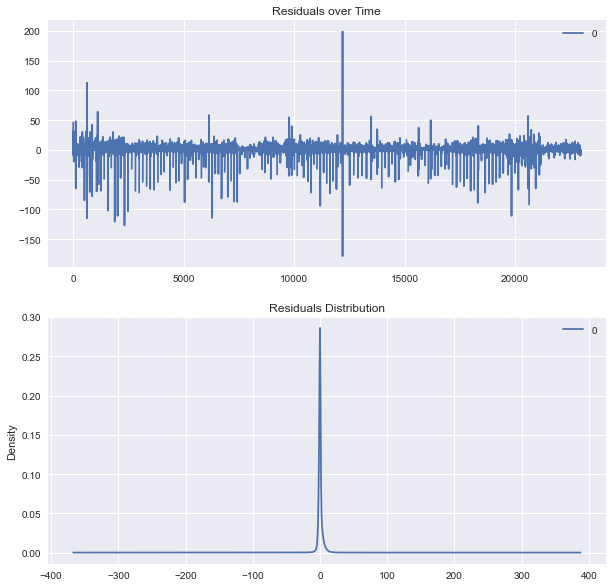

                  0
count  22858.000000
mean       0.004347
std        5.883237
min     -178.589386
25%       -0.998913
50%       -0.000015
75%        0.326271
max      198.892361


In [35]:
arima_resids = pd.DataFrame(arima_model_fit.resid)
resid_plotter(arima_resids)

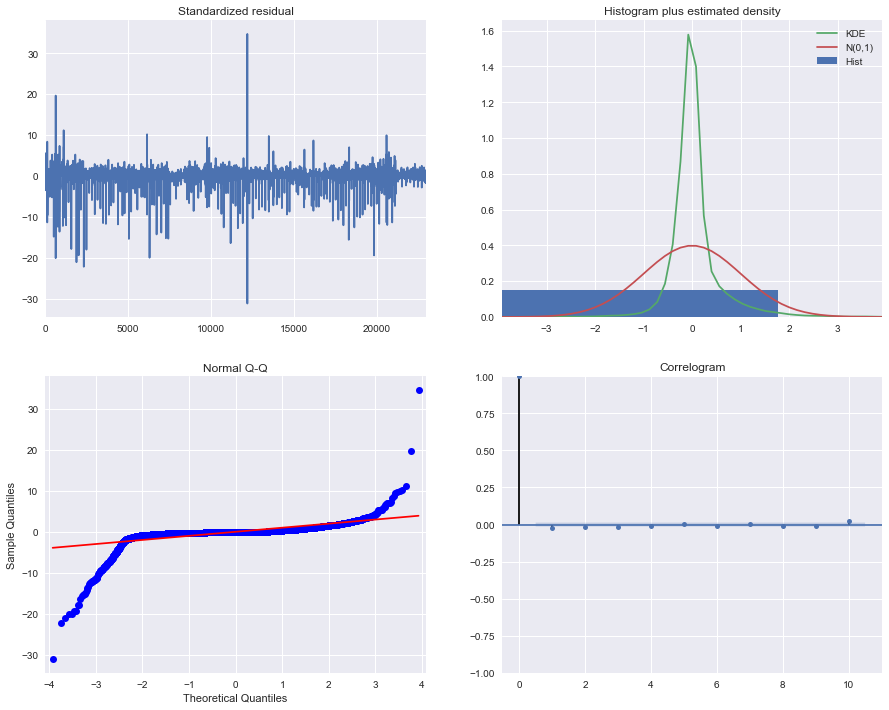

In [36]:
_ = arima_model_fit.plot_diagnostics(figsize=(15, 12))

there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

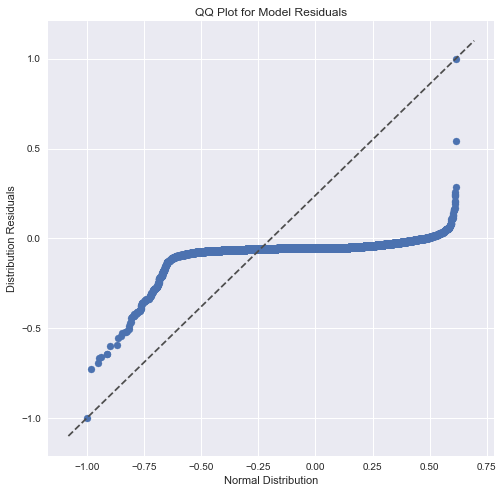

In [37]:
def resid_qqer(residuals):
    size = residuals.shape[0]
    normal = np.random.normal(0, .1, size)
    
    #scale data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    residuals = scaler.fit_transform(residuals.sort_values(by=0))
    normal.sort()
    normal = normal.reshape(-1, 1)
    normal = scaler.fit_transform(normal)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.scatter(x=normal, y=residuals)
    #plt.plot(normal, residuals, "o")
    plt.xlabel('Normal Distribution')
    plt.ylabel('Distribution Residuals')
    plt.title('QQ Plot for Model Residuals')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
    #plt.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()
resid_qqer(arima_resids)

In [72]:
start_d, end_d = '2004-08-01', '2006-07-30'
y_and_yhat_plotter(arima_model, co_base_ts, 
                   #query_filter='pseudo_ts>@start_d & pseudo_ts<@end_d'
                  )

TypeError: len() of unsized object

this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [ ]:
sarima_model = smt.arima.model.ARIMA(endog=month_ts_df.base, order=(0, 1, 1),
                                    seasonal_order=(0, 1, 0, 12))
sarima_model_fit = sarima_model.fit()

In [ ]:
sarima_model_fit.summary()

ARIMAX using snowfall data with powder -> packed powder and melt inference

#### Other models
GARCH, Gaussian Process, hidden Markov

### Bayesian Structural Model
[example bsm in R](https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/),  


### Panel Models
Linearmodels module?

# TF LSTM models
[use tensorflow probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html),  
[tfp example notebook: link](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb),  

In [ ]:
# scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

# invert transform
inverted_X = scaler.inverse_transform(scaled_X)



In [ ]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Prophet models